In [2698]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

from datetime import datetime

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import sqlite3

import math

In [2699]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [2700]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = 'data/' + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        self.start_time = None
        self.end_time = None

        # acceleration.csvがない場合は作成する
        if 'acceleration.csv' not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)
        
        # 'all.csv'がある場合は削除する
        if 'all.csv' in self.file_names:
            self.file_names.remove('all.csv')
        
        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace('.csv', '')

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(columns={'x': file_type + '_x', 'y': file_type + '_y', 'z': file_type + '_z'})
            
            # 'rotate.csv' に 'w' 列がある場合は削除
            if 'w' in df_tmp.columns and file_name == 'rotate.csv':
                df_tmp = df_tmp.drop(['w'], axis=1)

            if type(df_tmp['time'][0]) == int:
                # 'time'列の変換を実行
                df_tmp['time'] = df_tmp['time'] / 1000
                df_tmp['time'] = pd.to_datetime(df_tmp['time'], unit='s')

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[:, [0] + [i for i in range(1, len(self.df.columns)) if not self.df.columns[i].startswith('time')]]
        self.df['time'] =pd.to_datetime(self.df['time']/1000,unit='s')

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, 'all.csv'), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, 'velocity.csv'))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        df_acc['x'] = df_tmp['x'].cumsum()
        df_acc['y'] = df_tmp['y'].cumsum()
        df_acc['z'] = df_tmp['z'].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, 'acceleration.csv'), index=False)
        df_acc = df_acc.drop(['time'],axis =1 )
        df_acc['acceleration_x'] = df_acc['x']
        df_acc['acceleration_y'] = df_acc['y']
        df_acc['acceleration_z'] = df_acc['z']
        df_acc = df_acc.drop(['x', 'y', 'z'], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_low_x'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
            column = column_type + '_y'
            out_column = column_type + '_low_y'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
            column = column_type + '_z'
            out_column = column_type + '_low_z'
            self.df[out_column] = self.df[column].rolling(n,center = True).mean()
        return self

    def high_filter(self, column_type, n):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.high_filter(column, n)
        else:
            column = column_type + '_x'
            out_column = column_type + '_high_x'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_y'
            out_column = column_type + '_high_y'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
            column = column_type + '_z'
            out_column = column_type + '_high_z'
            self.df[out_column] = self.df[column] -  self.df[column].rolling(n,center = False).mean()
        return self
    
    def diff(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.diff(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_diff_x'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_y'
            out_column = column_type + '_diff_y'
            self.df[out_column] = self.df[column].diff()
            column = column_type + '_z'
            out_column = column_type + '_diff_z'
            self.df[out_column] = self.df[column].diff()
        return self
    
    def reverse(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.reverse(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_reverse_x'
            self.df[out_column] = self.df[column] * -1
            column = column_type + '_y'
            out_column = column_type + '_reverse_y'
            self.df[out_column] = self.df[column] * -1
            column = column_type + '_z'
            out_column = column_type + '_reverse_z'
            self.df[out_column] = self.df[column] * -1
        return self

    def non_minus(self,column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.non_minus(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_non_minus_x'
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
            column = column_type + '_y'
            out_column = column_type + '_non_minus_y'
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
            column = column_type + '_z'
            out_column = column_type + '_non_minus_z'
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
        return self
    
    def shift_minus(self, column_type):
        if column_type == 'all':
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    pass
                self.shift_minus(column)
        else:
            column = column_type + '_x'
            out_column = column_type + '_shift_minus_x'
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
            column = column_type + '_y'
            out_column = column_type + '_shift_minus_y'
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
            column = column_type + '_z'
            out_column = column_type + '_shift_minus_z'
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
        return self

    def plot(self, column_type ,option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))
        
        if column_type == 'all':
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace('.csv', '')
                if column == 'all':
                    continue
                self.ax(column, option,axis)
                self.i += 1
        else:
            column_type = column_type.replace('.csv', '')
            self.ax(column_type, option,axis)
        plt.show()

    def ax(self, column_type ,option,axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i+1)
        match option:
            case "axvspan":
                self.axvspan(column_type)
            case "diff":
                column_type = column_type + '_diff'
            case "high":
                column_type = column_type + '_high'
            case "low":
                column_type = column_type + '_low'  
            case "reverse":
                column_type = column_type + '_reverse'
            case "shift_minus":
                column_type = column_type + '_shift_minus'
            case "reverse":
                column_type = column_type + '_reverse'
            case "non_minus":
                column_type = column_type + '_non_minus'
        match axis:
            case 'x':
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
            case 'y':
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
            case 'z':
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
            case _:
                ax.plot(self.df['time'], self.df[column_type + '_x'], label = column_type + '_x')
                ax.plot(self.df['time'], self.df[column_type + '_y'], label = column_type + '_y')
                ax.plot(self.df['time'], self.df[column_type + '_z'], label = column_type + '_z')
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel('time')
        ax.set_ylabel(column_type)
        ax.grid()

    def axvspan(self,column_type):
        ax.axvspan(self.start_time, self.end_time, color='red', alpha=0.5)

    def split_time(self, start_time, end_time):
        self.df = self.df[(self.df['time'] >= start_time) & (self.df['time'] <= end_time)]
        return self

In [2701]:
# free_walkのデータを読み込む
free_walk = Data('free_walk')
free_walk.low_filter('all', filter_num)

## 階段登ってるかの判別

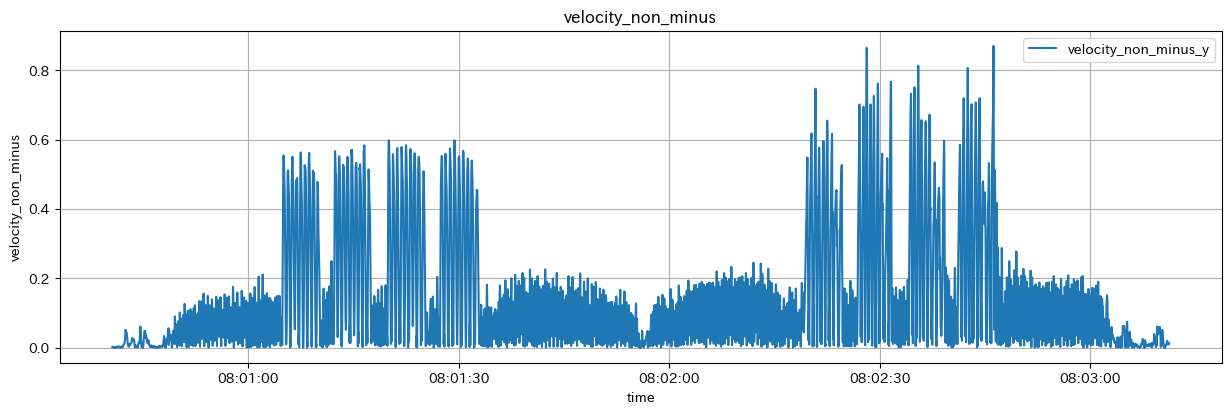

In [2702]:
free_walk.non_minus('velocity')
free_walk.plot('velocity', 'non_minus', 'y')

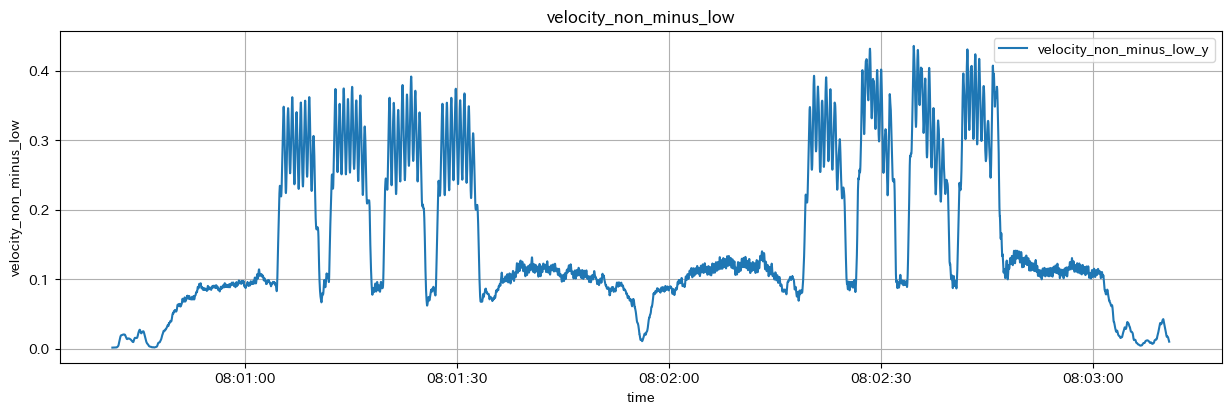

In [2703]:
free_walk.low_filter('velocity_non_minus', filter_num)
free_walk.plot('velocity_non_minus', 'low', 'y')

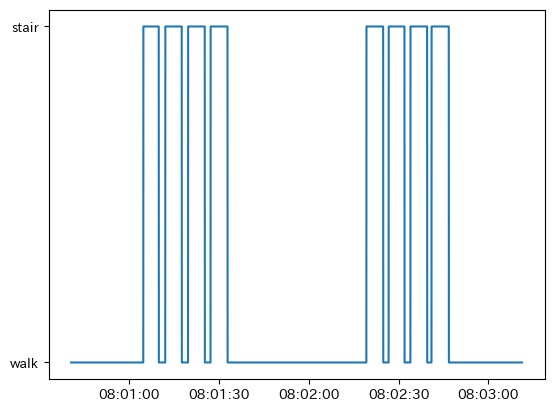

In [2704]:
# ['velocity_non_minus_low_y'] > 0.2 のときは status を 'stair'にするそれ以外は 'walk'にする
free_walk.df['status'] = free_walk.df['velocity_non_minus_low_y'].apply(lambda x: 'stair' if x > 0.2 else 'walk')
#plot
plt.plot(free_walk.df['time'], free_walk.df['status'])
plt.show()

## walkからstairに切り替わるときと、stairからwalkに切り替わるときのposition_yを比較する

In [2705]:
# walk → stair のインデックスを取得
walk_to_stair = free_walk.df[(free_walk.df['status'] == 'stair') & (free_walk.df['status'].shift() == 'walk')].index
print(walk_to_stair)
# 時間に変化
walk_to_stair_time = free_walk.df['time'][walk_to_stair]
print(walk_to_stair_time)

# stair → walk のインデックスを取得
stair_to_walk = free_walk.df[(free_walk.df['status'] == 'walk') & (free_walk.df['status'].shift() == 'stair')].index
print(stair_to_walk)
# 時間に変化
stair_to_walk_time = free_walk.df['time'][stair_to_walk]
print(stair_to_walk_time)

# walk → stair と stair → walk のインデックスの数が同じであることを確認
print(len(walk_to_stair))
print(len(stair_to_walk))

Index([1732, 2258, 2806, 3347, 7094, 7629, 8153, 8660], dtype='int64')
1732   2023-11-27 08:01:04.753999872
2258   2023-11-27 08:01:12.086999808
2806   2023-11-27 08:01:19.697999872
3347   2023-11-27 08:01:27.211000064
7094   2023-11-27 08:02:19.249000192
7629   2023-11-27 08:02:26.678999808
8153   2023-11-27 08:02:33.956000000
8660   2023-11-27 08:02:40.999000064
Name: time, dtype: datetime64[ns]
Index([2102, 2654, 3208, 3755, 7498, 8010, 8555, 9073], dtype='int64')
2102   2023-11-27 08:01:09.914000128
2654   2023-11-27 08:01:17.585999872
3208   2023-11-27 08:01:25.280000000
3755   2023-11-27 08:01:32.877000192
7498   2023-11-27 08:02:24.860000000
8010   2023-11-27 08:02:31.971000064
8555   2023-11-27 08:02:39.540000000
9073   2023-11-27 08:02:46.768999936
Name: time, dtype: datetime64[ns]
8
8


1.4890871404000001
1.574098
1.571749
1.580622
-1.5521140000000004
-1.539907
-1.5755810000000001
-1.53158483


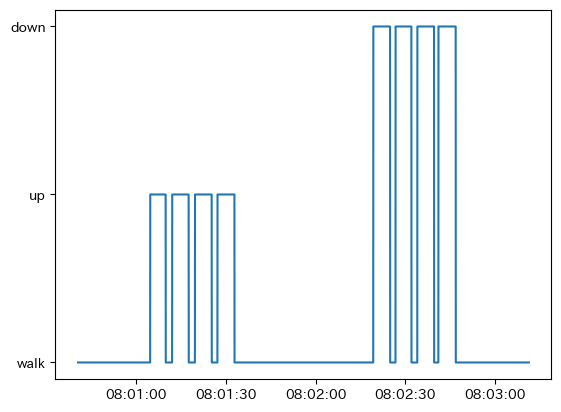

In [2706]:
# 前後のposition_yの差分を取得
for i in range(len(walk_to_stair)):
    y_diff = free_walk.df['position_y'][stair_to_walk[i]] - free_walk.df['position_y'][walk_to_stair[i]]
    print(y_diff)
    # plus なら status を 'up' にする
    # walk_to_stair[i] から stair_to_walk[i] までの status 書き換える
    if y_diff > 0:
        free_walk.df.loc[walk_to_stair[i]:stair_to_walk[i], 'status'] = 'up'
    # minus なら status を 'down' にする
    # walk_to_stair[i] から stair_to_walk[i] までの status 書き換える
    elif y_diff < 0:
        free_walk.df.loc[walk_to_stair[i]:stair_to_walk[i], 'status'] = 'down'

# plot
plt.plot(free_walk.df['time'], free_walk.df['status'])
plt.show()

In [2707]:
# # stair_to_walk と次の stair_to_walk の値に変化がない場合はその status を前の status にする
# for i in range(len(stair_to_walk) - 1):
#     if free_walk.df['status'][stair_to_walk[i]] == free_walk.df['status'][stair_to_walk[i+1]]:
#         free_walk.df.loc[stair_to_walk[i]:stair_to_walk[i+1], 'status'] = free_walk.df['status'][stair_to_walk[i]]

# plt.plot(free_walk.df['time'], free_walk.df['status'])
# plt.show()

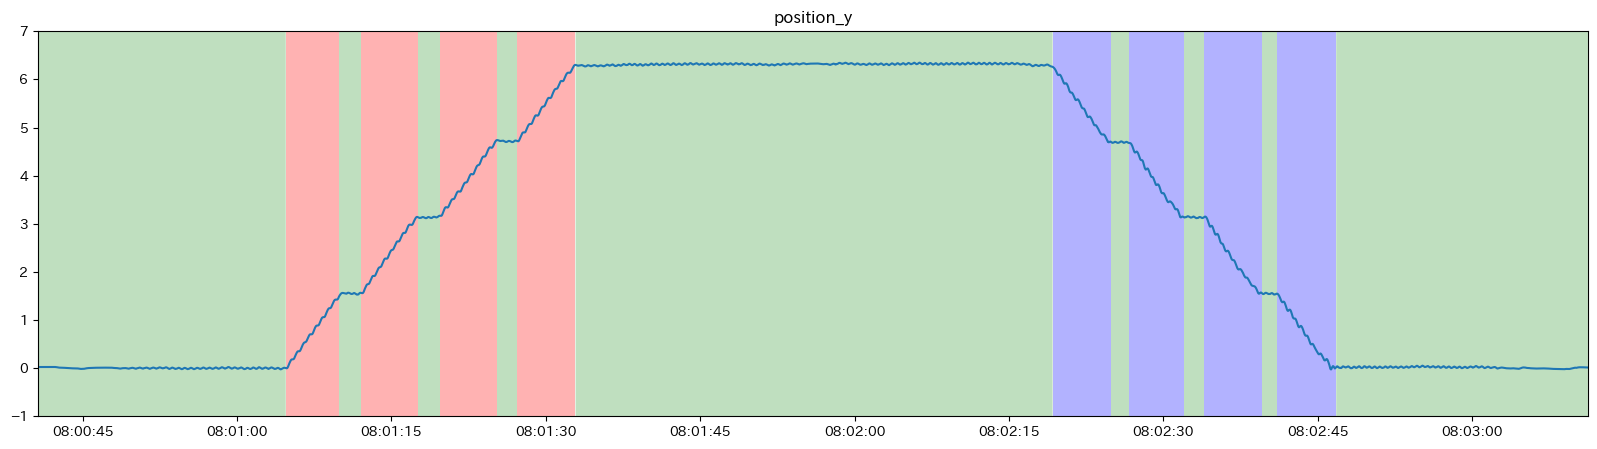

In [2708]:
# positon_y と status は背景に表示する
fig = plt.figure(figsize=(20, 5))
plt.title('position_y')
plt.plot(free_walk.df['time'], free_walk.df['position_y'])
plt.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
plt.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
plt.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
plt.ylim(-1,7)
plt.xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
plt.show()

## status が walk のときの歩数をとる

In [2709]:
# peakを取得する
# status が walk 以外のときの velocity_y を 0 にする
free_walk.df['velocity_walk_y'] = free_walk.df['velocity_y'].where(free_walk.df['status'] == 'walk', 0)

# ローパスフィルタ
free_walk.df['velocity_walk_low_y'] = free_walk.df['velocity_walk_y'].rolling(int(filter_num/4),center = True).mean()

peak, _ = find_peaks(free_walk.df['velocity_walk_low_y'], distance=22, height=0.01)

peak_walk_df = pd.DataFrame()
peak_walk_df['time'] = free_walk.df['time']

# indexの初期値を取得する
peak_walk_first = free_walk.df.index[0]
# peakに初期値を足す
peak = peak + peak_walk_first
# peakの時間を取得する
peak_walk_time = free_walk.df['time'][peak]

# 階段を登っているか、平面を歩いているかを判定する
# peakのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peak_walk_df['status'] = 'none'
for i in range(len(peak)):
    if free_walk.df['velocity_y'][peak[i]] > 0.01:
        peak_walk_df['status'][peak[i]] = 'walk'
    else:
        peak_walk_df['status'][peak[i]] = 'none'

# peak_dfからstatusがnoneの行を削除する
# peak_df = peak_df[peak_df['status'] != 'none']

# 階段を登る、平面を歩くを判定する
peak_walk_df = peak_walk_df[peak_walk_df['status'] == 'walk']

# それぞれのindexをリストに
peak_walks = [index for index in peak_walk_df.index]

# numpyに変換する
peak_walk_np = np.array(peak_walks)

peak_walk_time = free_walk.df['time'][peak_walk_np]

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/636928311.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_walk_df['status'][peak[i]] = 'walk'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/636928311.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_walk_df['status'][peak[i]] = 'walk'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/636928311.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

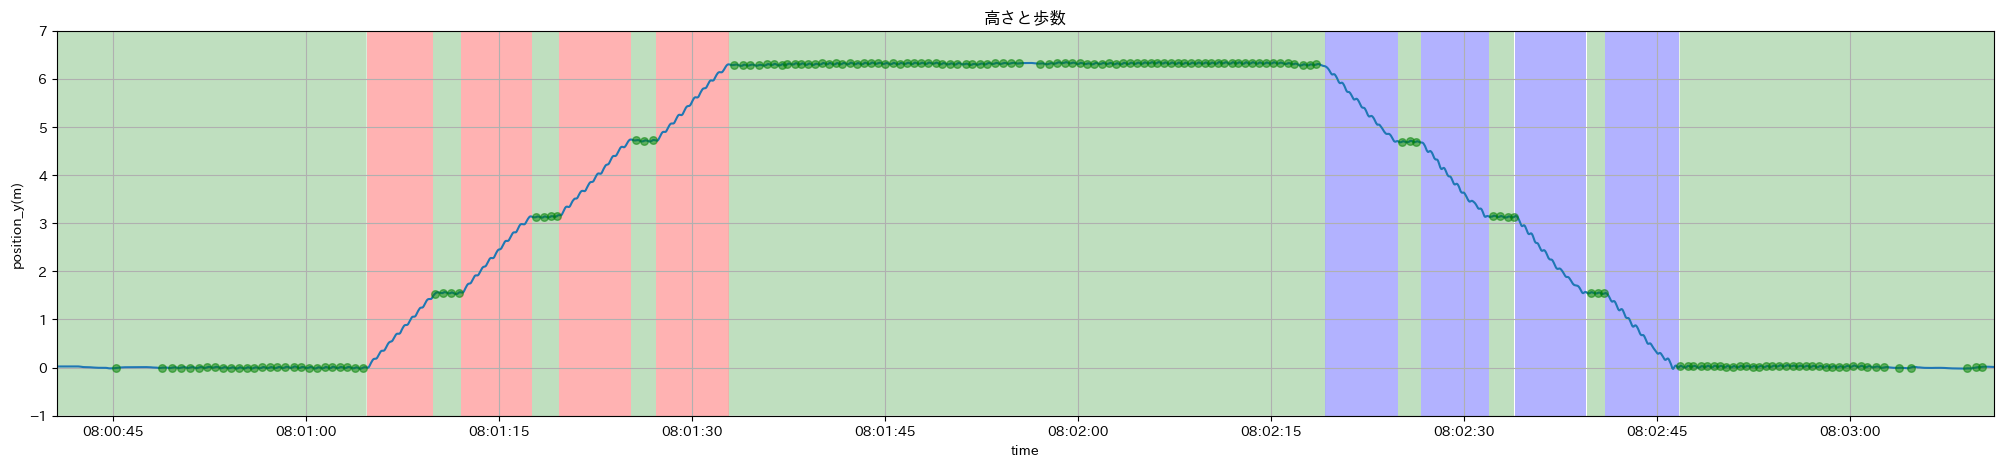

In [2710]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['position_y'])
# 後ろを全体で塗る
ax.scatter(peak_walk_time, free_walk.df['position_y'][peak_walk_np], s=30, color='green', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(-1,7)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()

In [2711]:
# peakを取得する
# status が walk 以外のときの velocity_y を 0 にする
free_walk.df['velocity_up_y'] = free_walk.df['velocity_y'].where(free_walk.df['status'] == 'up', 0)

# ローパスフィルタ
free_walk.df['velocity_up_low_y'] = free_walk.df['velocity_up_y'].rolling(int(filter_num/4),center = True).mean()

peak, _ = find_peaks(free_walk.df['velocity_up_low_y'], distance=22, height=0.01)

peak_up_df = pd.DataFrame()
peak_up_df['time'] = free_walk.df['time']

# indexの初期値を取得する
peak_up_first = free_walk.df.index[0]
# peakに初期値を足す
peak = peak + peak_up_first
# peakの時間を取得する
peak_up_time = free_walk.df['time'][peak]

# 階段を登っているか、平面を歩いているかを判定する
# peakのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peak_up_df['status'] = 'none'
for i in range(len(peak)):
    if free_walk.df['velocity_y'][peak[i]] > 0.3:
        peak_up_df['status'][peak[i]] = 'up'
    else:
        peak_up_df['status'][peak[i]] = 'none'

# 階段を登る、平面を歩くを判定する
peak_up_df = peak_up_df[peak_up_df['status'] == 'up']

# それぞれのindexをリストに
peak_ups = [index for index in peak_up_df.index]

# numpyに変換する
peak_up_np = np.array(peak_ups)

peak_up_time = free_walk.df['time'][peak_up_np]

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/1650375012.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_up_df['status'][peak[i]] = 'up'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/1650375012.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_up_df['status'][peak[i]] = 'up'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/1650375012.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

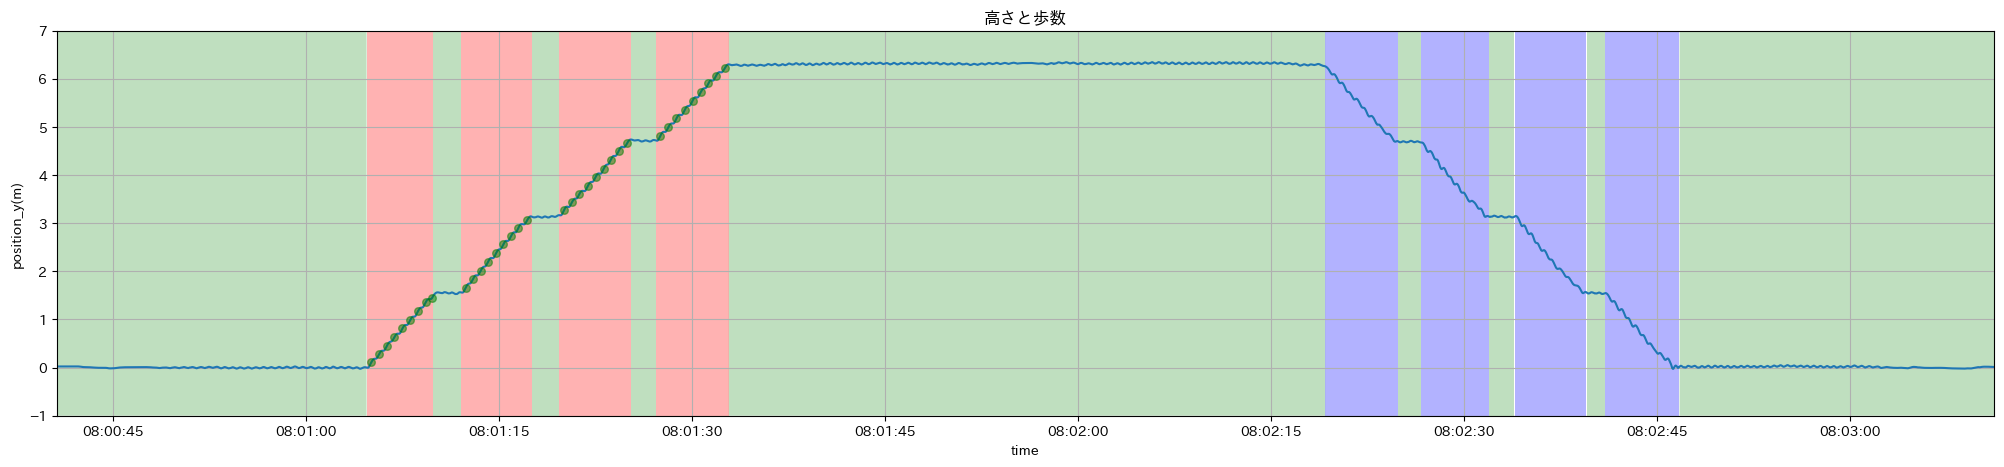

In [2712]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['position_y'])
# 後ろを全体で塗る
ax.scatter(peak_up_time, free_walk.df['position_y'][peak_up_np], s=30, color='green', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(-1,7)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()

In [2713]:
# peakを取得する

# velocity_yを反転させる
free_walk.reverse('velocity')
# status が walk 以外のときの velocity_y を 0 にする
free_walk.df['velocity_down_y'] = free_walk.df['velocity_reverse_y'].where(free_walk.df['status'] == 'down', 0)
# ローパスフィルタ
free_walk.df['velocity_down_low_y'] = free_walk.df['velocity_down_y'].rolling(int(filter_num/4),center = True).mean()

peak, _ = find_peaks(free_walk.df['velocity_down_low_y'], distance=22, height=0.01)

peak_down_df = pd.DataFrame()
peak_down_df['time'] = free_walk.df['time']

# indexの初期値を取得する
peak_down_first = free_walk.df.index[0]
# peakに初期値を足す
peak = peak + peak_down_first
# peakの時間を取得する
peak_down_time = free_walk.df['time'][peak]

# 階段を登っているか、平面を歩いているかを判定する
# peakのときのvelocity_yの値が0.2を超えていたら階段を登っていると判定する、それ以外のときは平面
peak_down_df['status'] = 'none'
for i in range(len(peak)):
    if free_walk.df['velocity_reverse_y'][peak[i]] > 0.3:
        peak_down_df['status'][peak[i]] = 'down'
    else:
        peak_down_df['status'][peak[i]] = 'none'

# 階段を登る、平面を歩くを判定する
peak_down_df = peak_down_df[peak_down_df['status'] == 'down']

# それぞれのindexをリストに
peak_downs = [index for index in peak_down_df.index]

# numpyに変換する
peak_down_np = np.array(peak_downs)

peak_down_time = free_walk.df['time'][peak_down_np]

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/2634516561.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_down_df['status'][peak[i]] = 'down'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/2634516561.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_down_df['status'][peak[i]] = 'down'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/2634516561.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

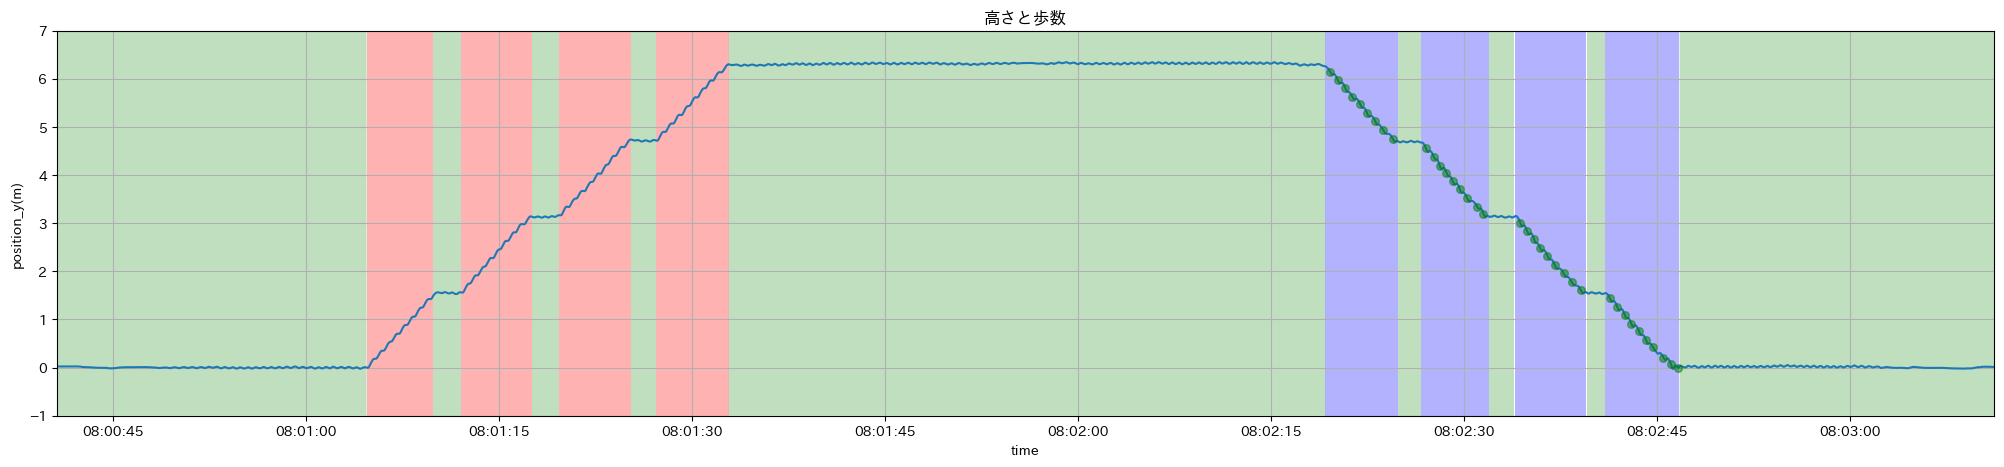

In [2714]:
# position_pro_yとpositionのplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['position_y'])
# 後ろを全体で塗る
ax.scatter(peak_down_time, free_walk.df['position_y'][peak_down_np], s=30, color='green', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(-1,7)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()

In [2715]:
# # 時系列順にpeakを結合する
# peak_df = pd.concat([peak_walk_df, peak_up_df, peak_down_df])
# peak_df = peak_df.sort_values('time')

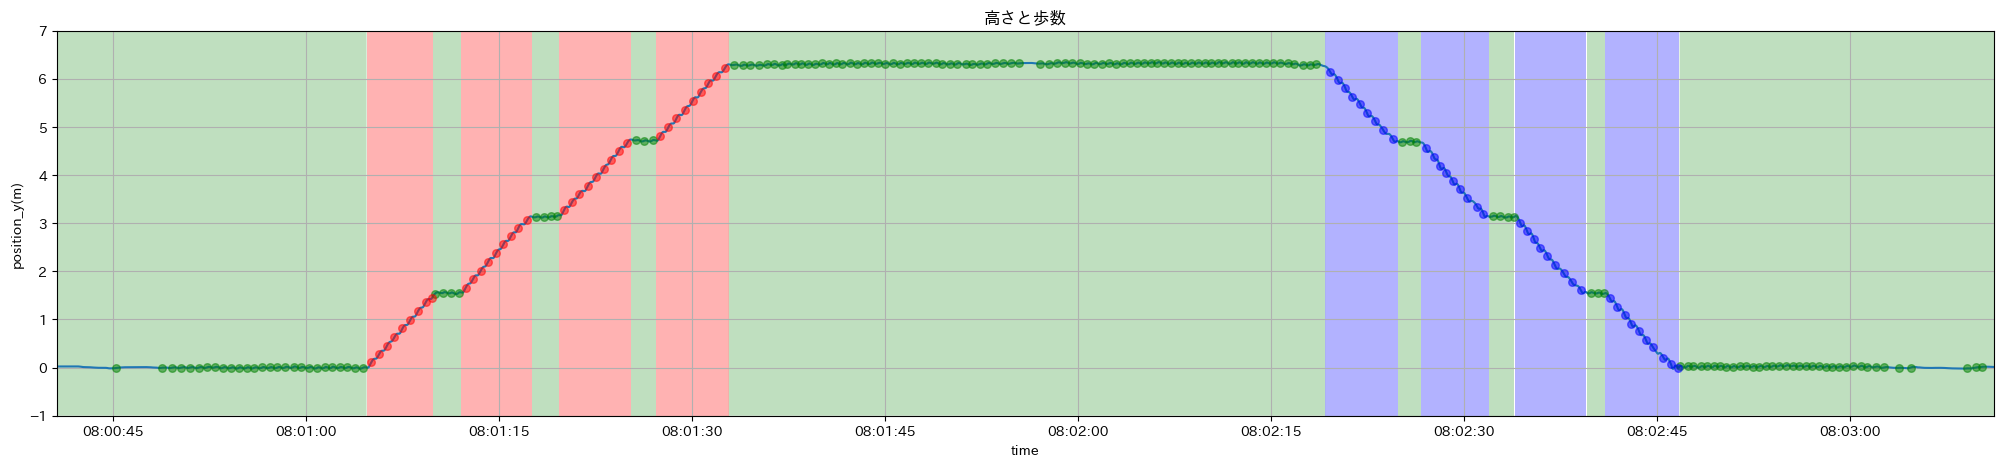

In [2716]:
# positionに合わせて peak をplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['position_y'])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(peak_walk_df['time'], free_walk.df['position_y'][peak_walk_df.index], s=30, color='green', zorder=2,alpha=0.5)
# status が up の peak を plot
ax.scatter(peak_up_df['time'], free_walk.df['position_y'][peak_up_df.index], s=30, color='red', zorder=2,alpha=0.5)
# status が down の peak を plot
ax.scatter(peak_down_df['time'], free_walk.df['position_y'][peak_down_df.index], s=30, color='blue', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(-1,7)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()


## 階段の段数の補正

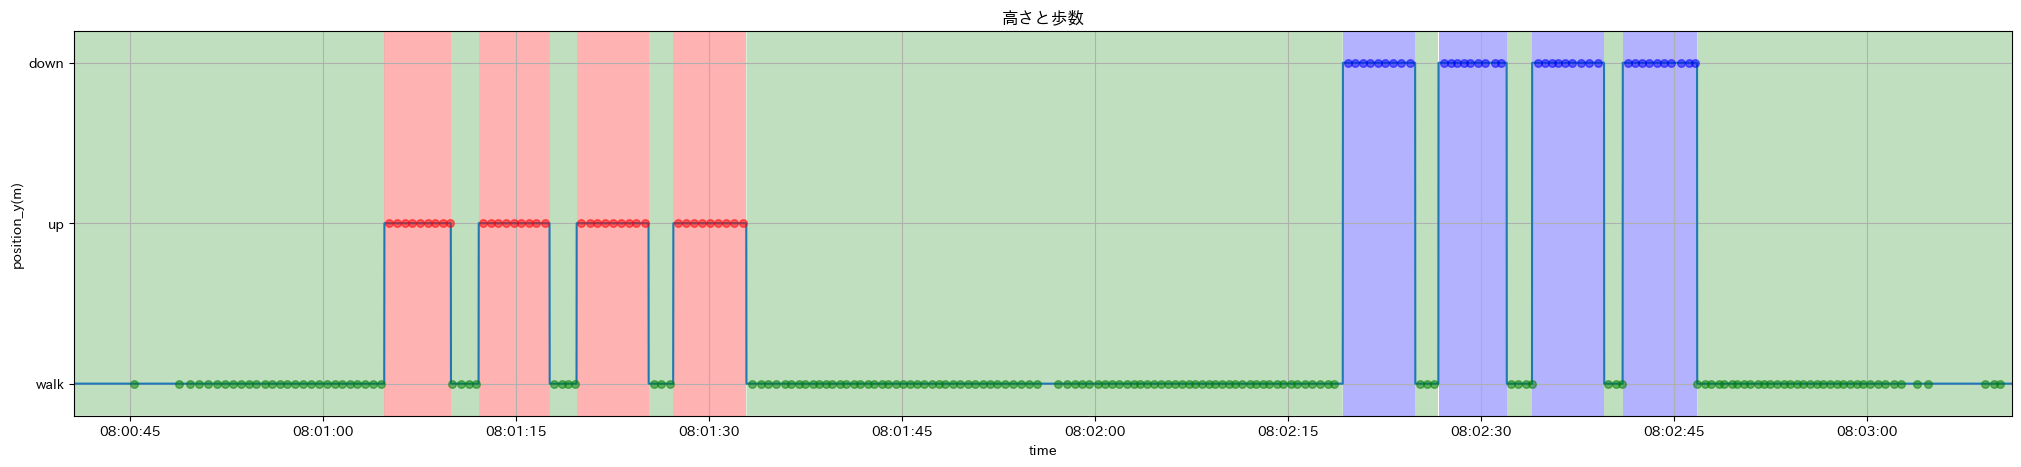

In [2717]:
# status と peak を plot
top = 2.2
bottom = -0.2

fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['status'])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(peak_walk_df['time'], free_walk.df['status'][peak_walk_df.index], s=30, color='green', zorder=2,alpha=0.5)
# status が up の peak を plot
ax.scatter(peak_up_df['time'], free_walk.df['status'][peak_up_df.index], s=30, color='red', zorder=2,alpha=0.5)
# status が down の peak を plot
ax.scatter(peak_down_df['time'], free_walk.df['status'][peak_down_df.index], s=30, color='blue', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], bottom,top, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], bottom,top, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], bottom,top, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(bottom,top)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()

In [2718]:
steps = pd.DataFrame(columns=['status','number','step'])

# 数える関数
def len_step(steps,status,peaks):
    counter = 0
    for i in peaks:
        # status, 何番目の階段か, 何段かを追加する
        tmp = pd.DataFrame({'status': [status], 'number': [counter], 'step': [len(i)]})
        steps = pd.concat([steps, tmp], ignore_index=True)
        counter += 1
    return steps

def remove_walk_peak(peak):
    global peak_walk_df
    # peak_walk_df の中で peak にもっとも近い index をもつものを削除する
    for i in peak:
        # peak_walk_df の中で peak にもっとも近い index をもつものを削除する
        peak_walk_df.drop(peak_walk_df.index[(peak_walk_df.index - i).abs().argsort()[0]], inplace=True)

def insert_walk_peak(peak):
    global peak_walk_df
    peak_time = free_walk.df['time'][peak]
    tmp = pd.DataFrame({'time': [peak_time], 'status': ['walk']})
    # peak_walk_df の中に peak を追加する
    peak_walk_df = pd.concat([peak_walk_df, tmp])
    # 並べ替え
    peak_walk_df = peak_walk_df.sort_values('time')
    # free_walk.df から time を参照して index を取得する
    peak_walk_df.index = free_walk.df.index[free_walk.df['time'].isin(peak_walk_df['time'])]

In [2719]:
ups = []
tmp = []
count = 0
# status が up で連続している区間を取得する
for i in free_walk.df.index:
    try:
        before_status = free_walk.df['status'][i - 1]
    except:
        before_status = 'walk'
    status = free_walk.df['status'][i]
    if status == 'up' and before_status == 'walk':
        tmp.append(i)
    elif before_status == 'up' and status == 'walk' :
        tmp.append(i)
        ups.append(tmp)
        tmp = []

# up が連続している区間の中の peak を取得する
peak_ups = []
for up in ups:
    tmp = []
    for peak in peak_up_df.index:
        if up[0] < peak and peak < up[1]:
            tmp.append(peak)
    peak_ups.append(tmp)
# 数える
steps = len_step(steps,'up',peak_ups)

In [2720]:
downs = []
tmp = []
count = 0
# status が down で連続している区間を取得する
for i in free_walk.df.index:
    try:
        before_status = free_walk.df['status'][i - 1]
    except:
        before_status = 'walk'
    status = free_walk.df['status'][i]
    if status == 'down' and before_status == 'walk':
        tmp.append(i)
    elif before_status == 'down' and status == 'walk' :
        tmp.append(i)
        downs.append(tmp)
        tmp = []

# down が連続している区間の中の peak を取得する
peak_downs = []
for down in downs:
    tmp = []
    for peak in peak_down_df.index:
        if down[0] < peak and peak < down[1]:
            tmp.append(peak)
    peak_downs.append(tmp)

# 数える
steps = len_step(steps,'down',peak_downs)

In [2721]:
# 誤った値を修正する関数
def process_peaks(step, peak, start, end):
    first = peak[0]
    last = peak[len(peak)-1]
    first_diff = abs(start - first)
    last_diff = abs(end - last)
    if step > step_median:
        if first_diff > last_diff:
            peak.remove(first)
            # peak_walk_df に first を追加する
            insert_walk_peak(first)
        else:
            peak.remove(last)
            # peak_walk_df に last を追加する
            insert_walk_peak(last)
    else:
        # peak_walk_df でそのpeakの値から一番近い値を探す
        if first_diff > last_diff:
            peak.append(first)
            remove_walk_peak(first)
        else:
            peak.append(last)
            remove_walk_peak(last)
    return peak

def collect_peaks(step):
    status = steps['status'][i]
    number = steps['number'][i]
    if status == 'up':
        start = ups[number][0]
        end = ups[number][1]
        peak_ups[number] = process_peaks(step, peak_ups[number], start, end)
    elif status == 'down':
        start = downs[number][0]
        end = downs[number][1]
        peak_downs[number] = process_peaks(step, peak_downs[number], start, end)
    return peak_ups, peak_downs

In [2722]:
# 中央値を取得する
step_median = steps['step'].median()

# step_median に適合しないものを探す
while True:
    for i in steps.index:
        step = steps['step'][i]
        if step == step_median:
            continue
        peak_ups, peak_downs = collect_peaks(step)
        status = steps['status'][i]
        if status == 'up':
            steps.loc[i, 'step'] = len(peak_ups[steps['number'][i]])
        elif status == 'down':
            steps.loc[i, 'step'] = len(peak_downs[steps['number'][i]])
    step_median = steps['step'].median()
    if step_median == step:
        break

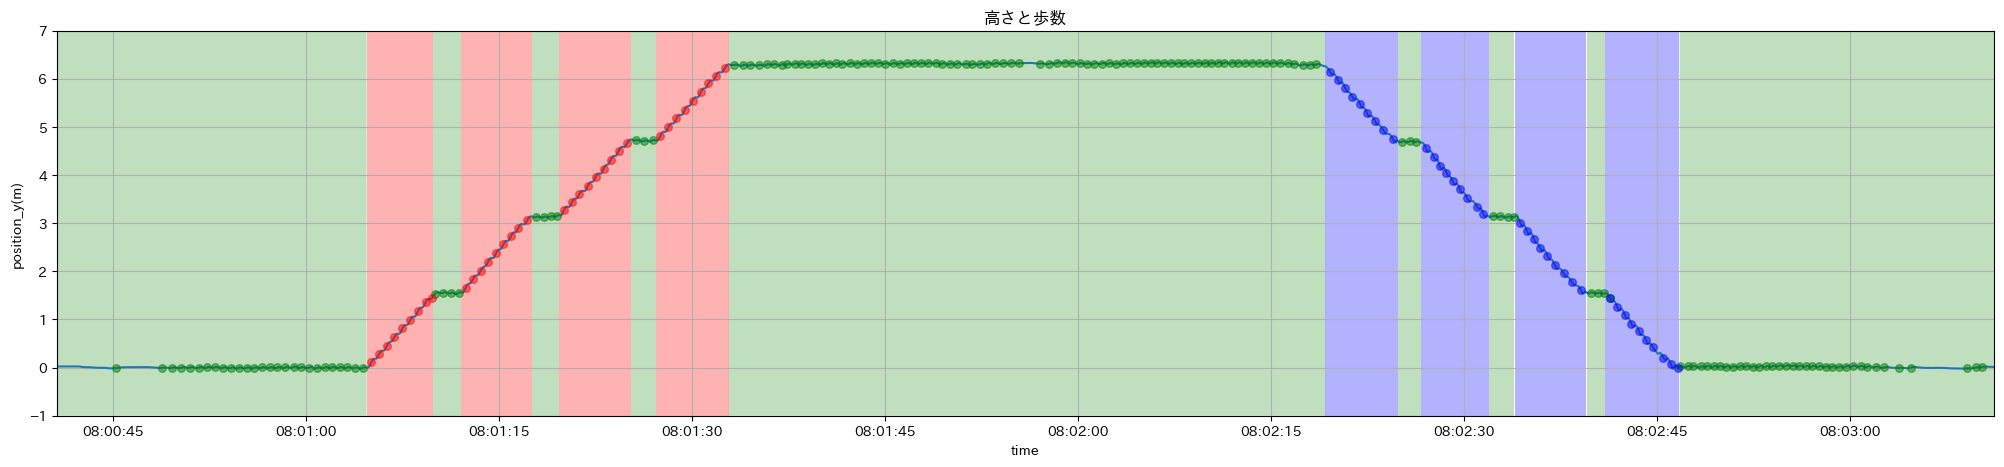

In [2723]:
# positionに合わせて peak をplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['position_y'])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(peak_walk_df['time'], free_walk.df['position_y'][peak_walk_df.index], s=30, color='green', zorder=2,alpha=0.5)
# status が up の peak を plot
ax.scatter(peak_up_df['time'], free_walk.df['position_y'][peak_up_df.index], s=30, color='red', zorder=2,alpha=0.5)
# status が down の peak を plot
ax.scatter(peak_down_df['time'], free_walk.df['position_y'][peak_down_df.index], s=30, color='blue', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)
ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(-1,7)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()


## 踊り場の長さを取得

In [2724]:
# up, down の連続する区間での stair → walk から walk → stair の歩数の平均を取得する
# up の連続する区間 ups
# down の連続する区間 downs

landings = []
for i in range(len(ups)-1):
    tmp = []
    tmp.append(ups[i][1])
    tmp.append(ups[i+1][0])
    landings.append(tmp)
    tmp = []
for i in range(len(downs)-1):
    tmp = []
    tmp.append(downs[i][1])
    tmp.append(downs[i+1][0])
    landings.append(tmp)
    tmp = []

In [2725]:
step_counts = 0
for landing in landings:
    # landing[0]からlandring[1]までのindexの中で peak_walk_df が持つ peakの数 を取得する
    for peak in peak_walk_df.index:
        if landing[0] < peak and peak < landing[1]:
            step_counts += 1

# 平均の歩数を取得する(四捨五入)
step_counts_mean = round(step_counts / len(landings))

print(step_counts_mean)

4


## 回転量をとる

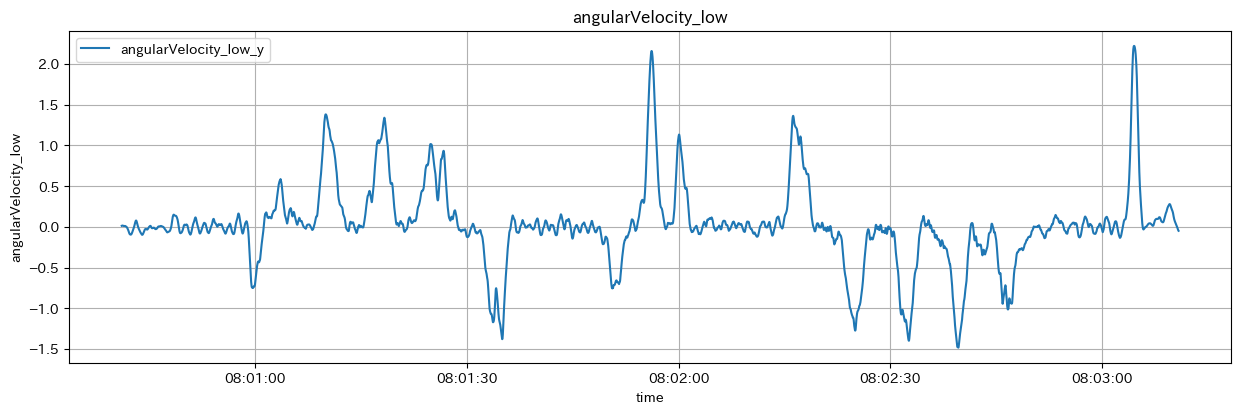

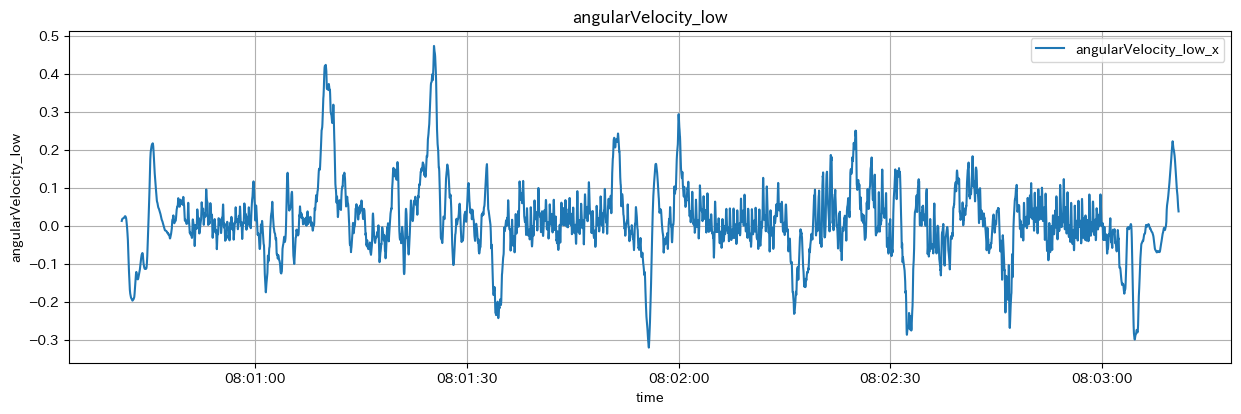

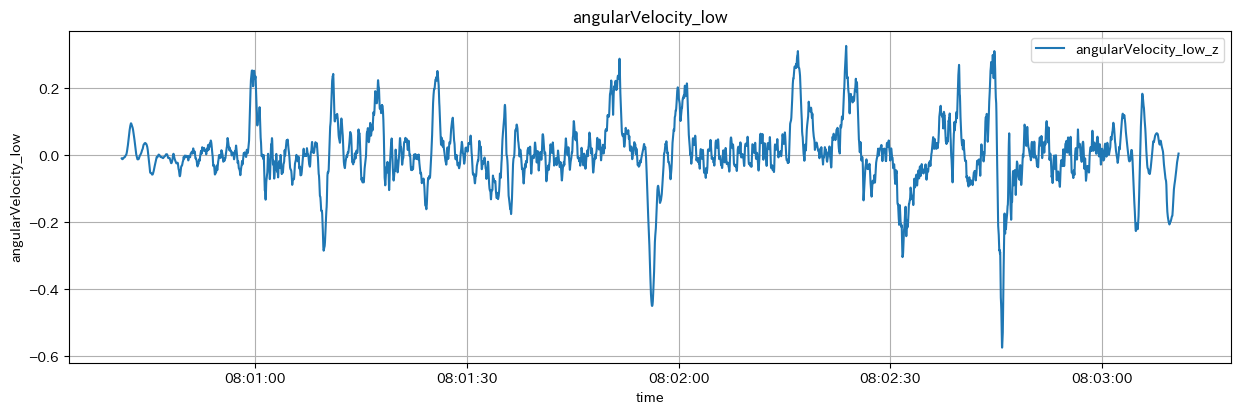

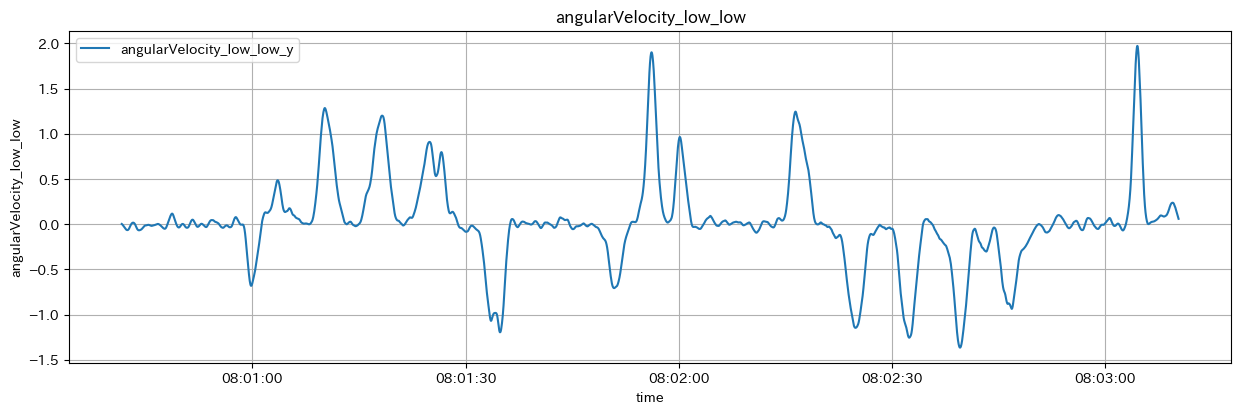

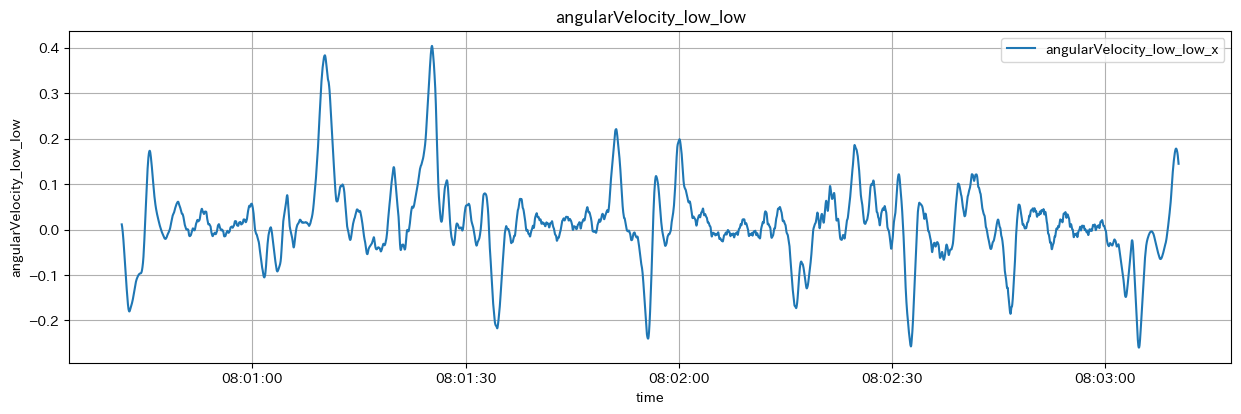

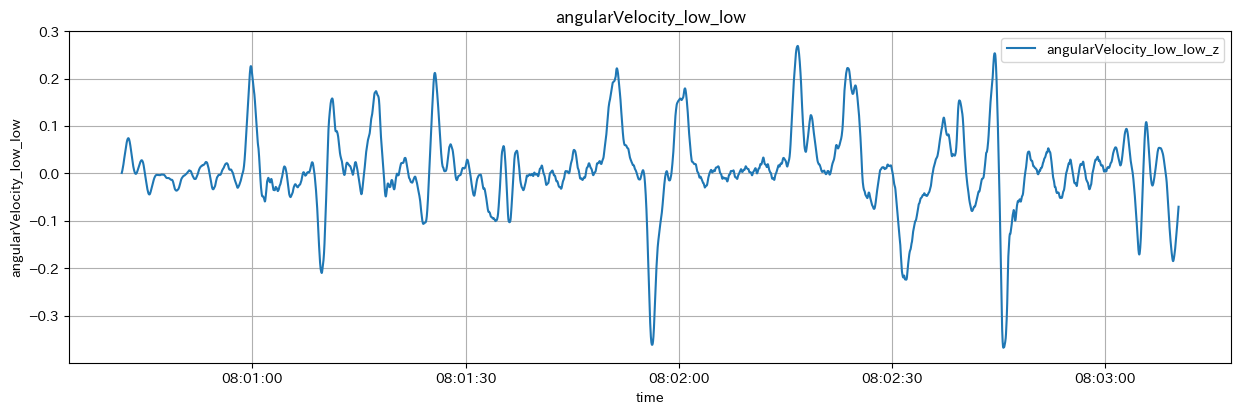

In [2726]:
free_walk.low_filter('angularVelocity_low', filter_num*4)
free_walk.plot('angularVelocity', 'low', 'y')
free_walk.plot('angularVelocity', 'low', 'x')
free_walk.plot('angularVelocity', 'low', 'z')
free_walk.plot('angularVelocity_low', 'low', 'y')
free_walk.plot('angularVelocity_low', 'low', 'x')
free_walk.plot('angularVelocity_low', 'low', 'z')

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/2145072333.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_velocity_df['status'][peak_velocity[i]] = 'left'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/2145072333.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_velocity_df['status'][peak_velocity[i]] = 'right'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/2145072333.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

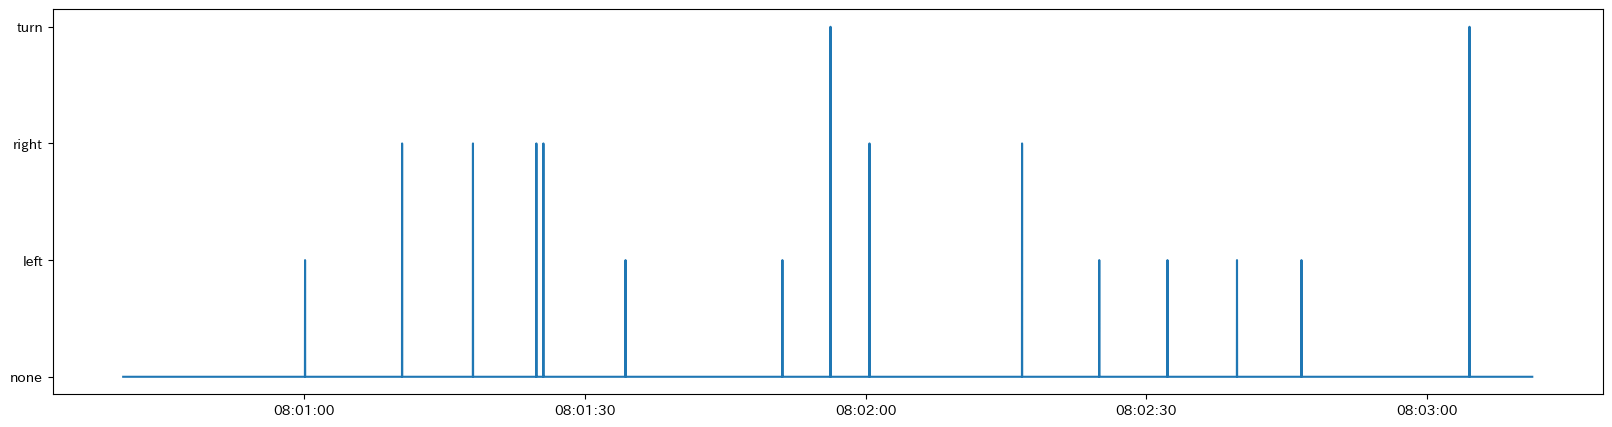

In [2727]:
# peakを取得する
free_walk.low_filter('angularVelocity_low', filter_num*2)
free_walk.non_minus('angularVelocity_low_low')
peak_velocity, _ = find_peaks(free_walk.df['angularVelocity_low_low_non_minus_y'], distance=33, height=0.4)

peak_velocity_df = pd.DataFrame()
peak_velocity_df['time'] = free_walk.df['time']

# indexの初期値を取得する
peak_velocity_first = free_walk.df.index[0]
# peakに初期値を足す
peak_velocity = peak_velocity + peak_velocity_first

# peakの時間を取得する
peak_velocity_time = free_walk.df['time'][peak_velocity]

# 右に曲がったか左に曲がったかを判定する
peak_velocity_df['status'] = 'none'
for i in range(len(peak_velocity)):
    if free_walk.df['angularVelocity_low_y'][peak_velocity[i]] > 2:
        peak_velocity_df['status'][peak_velocity[i]] = 'turn'
    elif free_walk.df['angularVelocity_low_y'][peak_velocity[i]] > 0:
        peak_velocity_df['status'][peak_velocity[i]] = 'right'
    else:
        peak_velocity_df['status'][peak_velocity[i]] = 'left'

peak_left = peak_velocity_df[peak_velocity_df['status'] == 'left']
peak_right = peak_velocity_df[peak_velocity_df['status'] == 'right']
peak_turn = peak_velocity_df[peak_velocity_df['status'] == 'turn']

# リストに
peak_lefts = [index for index in peak_left.index]
peak_rights = [index for index in peak_right.index]
peak_turns = [index for index in peak_turn.index]

# numpyに変換する
peak_left_np = np.array(peak_lefts)
peak_right_np = np.array(peak_rights)
peak_turn_np = np.array(peak_turns)

peak_left_time = free_walk.df['time'][peak_left_np]
peak_right_time = free_walk.df['time'][peak_right_np]
peak_turn_time = free_walk.df['time'][peak_turn_np]

# plot
fig = plt.figure(figsize=(20, 5))
plt.plot(peak_velocity_df['time'], peak_velocity_df['status'])
plt.show()

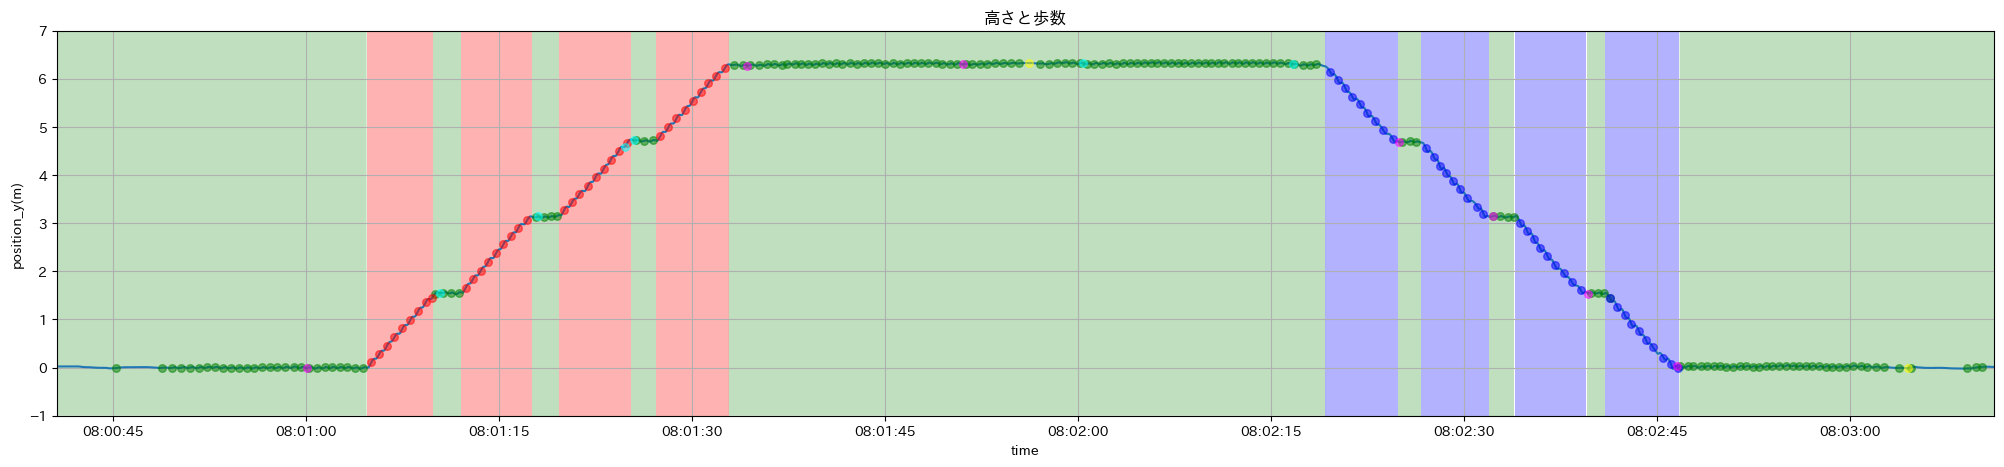

In [2728]:
# positionに合わせて peak をplot
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(free_walk.df['time'], free_walk.df['position_y'])
# 後ろを全体で塗る
# status が walk の peak を plot
ax.scatter(peak_walk_df['time'], free_walk.df['position_y'][peak_walk_df.index], s=30, color='green', zorder=2,alpha=0.5)
# status が up の peak を plot
ax.scatter(peak_up_df['time'], free_walk.df['position_y'][peak_up_df.index], s=30, color='red', zorder=2,alpha=0.5)
# status が down の peak を plot
ax.scatter(peak_down_df['time'], free_walk.df['position_y'][peak_down_df.index], s=30, color='blue', zorder=2,alpha=0.5)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'up', facecolor='red', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'down', facecolor='blue', alpha=0.3)
ax.fill_between(free_walk.df['time'], -1,7, where=free_walk.df['status'] == 'walk', facecolor='green', alpha=0.25)

# 回転のpeakをplot
ax.scatter(peak_left_time, free_walk.df['position_y'][peak_left_np], s=30, color='Magenta', zorder=2,alpha=0.5)
ax.scatter(peak_right_time, free_walk.df['position_y'][peak_right_np], s=30, color='Cyan', zorder=2,alpha=0.5)
ax.scatter(peak_turn_time, free_walk.df['position_y'][peak_turn_np], s=30, color='Yellow', zorder=2,alpha=0.5)

ax.set_title('高さと歩数')
ax.set_xlabel('time')
ax.set_ylabel('position_y(m)')
ax.set_ylim(-1,7)
ax.set_xlim(free_walk.df['time'][0], free_walk.df['time'][len(free_walk.df)-1])
ax.grid()
plt.show()

/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/3369762924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_direction['status'][peak_left.index[i]] = 'left'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/3369762924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_direction['status'][peak_left.index[i]] = 'left'
/var/folders/qx/g75h6sns4slc8l4sb8lsy3l00000gn/T/ipykernel_61259/3369762924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

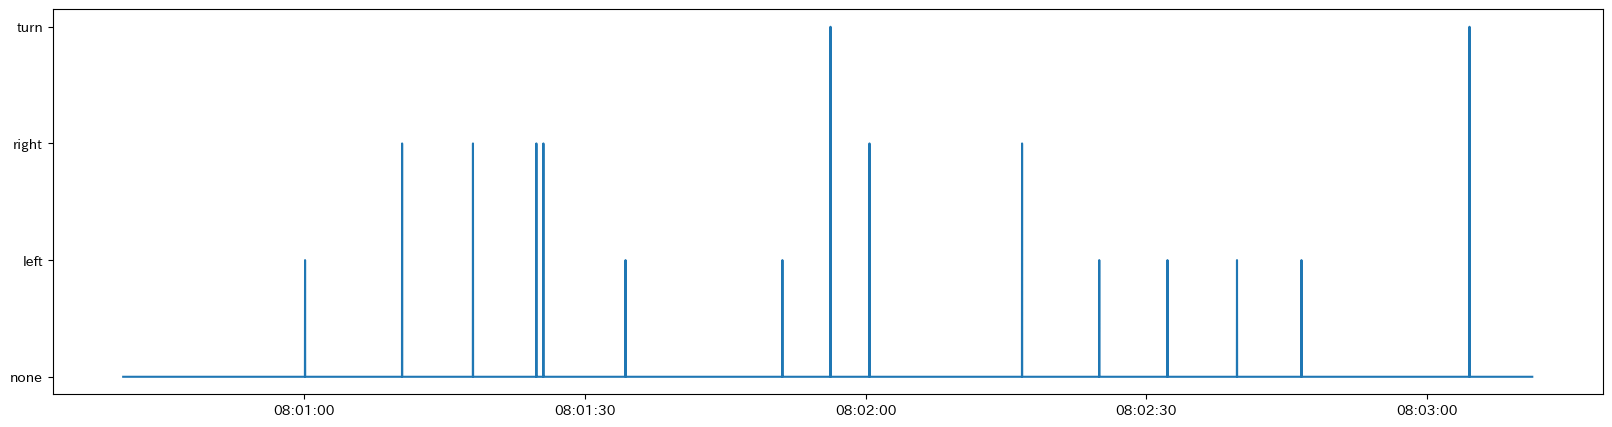

In [2729]:
# left ,right, turn をまとめる
peak_direction = pd.DataFrame()
peak_direction['time'] = free_walk.df['time']
peak_direction['status'] = 'none'
for i in range(len(peak_left)):
    peak_direction['status'][peak_left.index[i]] = 'left'
for i in range(len(peak_right)):
    peak_direction['status'][peak_right.index[i]] = 'right'
for i in range(len(peak_turn)):
    peak_direction['status'][peak_turn.index[i]] = 'turn'

# plot
fig = plt.figure(figsize=(20, 5))
plt.plot(peak_direction['time'], peak_direction['status'])
plt.show()

In [2734]:
# 階段のある区間は削除する
ups_lange = len(ups)
downs_lange = len(downs)

stair_lange = []
tmp = []
tmp.append(ups[0][0])
tmp.append(ups[ups_lange-1][1])
stair_lange.append(tmp)

tmp = []
tmp.append(downs[0][0])
tmp.append(downs[downs_lange-1][1])
stair_lange.append(tmp)

# 階段区間内での回転した方向を取得する
stair_direction = []
for i in range(len(stair_lange)):
    tmp = []
    tmp.append(stair_lange[i][0])
    tmp.append(stair_lange[i][1])
    counts = peak_direction['status'][stair_lange[i][0]:stair_lange[i][1]].value_counts()
    if len(counts) > 0:
        tmp.append(counts.index[0])
    else:
        tmp.append(None)  # または適切なデフォルト値
    stair_direction.append(tmp)

# 階段のある区間を削除する
for i in stair_lange:
    peak_direction = peak_direction.drop(peak_direction.index[(peak_direction.index >= i[0]) & (peak_direction.index <= i[1])])

# そのかわりに階段区間の始まりと終わりで回転させる
print(stair_direction)

[[1732, 3756, 'none'], [7094, 9074, None]]


In [2732]:
print(peak_direction)

                               time status
0     2023-11-27 08:00:40.653000192   none
1     2023-11-27 08:00:40.668000000   none
2     2023-11-27 08:00:40.681999872   none
3     2023-11-27 08:00:40.704000000   none
4     2023-11-27 08:00:40.720000000   none
...                             ...    ...
10829 2023-11-27 08:03:11.176000000   none
10830 2023-11-27 08:03:11.191000064   none
10831 2023-11-27 08:03:11.208000000   none
10832 2023-11-27 08:03:11.217999872   none
10833 2023-11-27 08:03:11.231000064   none

[6828 rows x 2 columns]


In [2731]:
# 向いている方向を取得する
# front , back , left , right のいずれか
# left : front → left , back → right , left → back , right → front
# right : front → right , back → left , left → front , right → back
# turn : front → back , back → front , left → right , right → left

free_walk.df['direction'] = 'none'
for i in free_walk.df.index:
    try:
        before_status = free_walk.df['direction'][i - 1]
    except:
        before_status = 'front'
    match peak_direction['status'][i]:
        case 'left':
            if before_status == 'front':
                free_walk.df.loc[i, 'direction'] = 'left'
            elif before_status == 'back':
                free_walk.df.loc[i, 'direction'] = 'right'
            elif before_status == 'left':
                free_walk.df.loc[i, 'direction'] = 'back'
            elif before_status == 'right':
                free_walk.df.loc[i, 'direction'] = 'front'
        case 'right':
            if before_status == 'front':
                free_walk.df.loc[i, 'direction'] = 'right'
            elif before_status == 'back':
                free_walk.df.loc[i, 'direction'] = 'left'
            elif before_status == 'left':
                free_walk.df.loc[i, 'direction'] = 'front'
            elif before_status == 'right':
                free_walk.df.loc[i, 'direction'] = 'back'
        case 'turn':
            if before_status == 'front':
                free_walk.df.loc[i, 'direction'] = 'back'
            elif before_status == 'back':
                free_walk.df.loc[i, 'direction'] = 'front'
            elif before_status == 'left':
                free_walk.df.loc[i, 'direction'] = 'right'
            elif before_status == 'right':
                free_walk.df.loc[i, 'direction'] = 'left'
        case _:
            free_walk.df.loc[i, 'direction'] = before_status

# plot
fig = plt.figure(figsize=(20, 5))
plt.plot(free_walk.df['time'], free_walk.df['direction']) 
plt.plot(peak_direction['time'], peak_direction['status'])
plt.show()


KeyError: 1732